In [11]:
from collections import defaultdict
import glob
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from netCDF4 import Dataset
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
dst_crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
from pyresample.geometry import AreaDefinition
from skimage.util import view_as_windows
from IPython.display import Image

%matplotlib inline

In [39]:
sat_speed = 6576.1337527911755

rho_water = 1026
rho_snow = 400
rho_ice = 917

dst_xmin = -3000000
dst_ymin = -3000000
dst_xmax = 3000000
dst_ymax = 3000000
dst_res = 6000
dst_width = int((dst_xmax - dst_xmin) / dst_res)
dst_height = int((dst_ymax - dst_ymin) / dst_res)
dst_extent = [dst_xmin, dst_ymin, dst_xmax, dst_ymax]
dst_proj4_string = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +x_0=0 +y_0=0 +a=6378273 +rf=298.27940986765 +units=m +no_defs +type=crs'
dst_area = AreaDefinition('area_id', 'descr', 'proj_id', dst_proj4_string, dst_width, dst_height, dst_extent)

img_extent = [dst_xmin, dst_xmax, dst_ymax, dst_ymin]
fig_xlim = [dst_xmin+600000, dst_xmax-1700000]
fig_ylim = [dst_ymin+1900000, dst_ymax-700000]
subplot_size=5

sit_names = ['cs2', 'inp', 'lor', 'hir']
p_vec = (10,20,30)

date_delta0, date_delta1 = -2, 2

In [43]:
def get_filenames(date0, date_delta0, date_delta1):
    cs2_dir = '/Data/sat/downloads/CS2/SIR_GDR/2021/01'
    cs2_files = []
    for timedelta in range(date_delta0, date_delta1+1):
        cs2_date = date0 + dt.timedelta(timedelta)
        cs2_date_str = cs2_date.strftime('%Y%m%d')
        cs2_files.extend(sorted(glob.glob(f'{cs2_dir}/CS_OFFL_SIR_GDR_2__{cs2_date_str}*D001.nc')))
    print(len(cs2_files))

    npz_name = date0.strftime('%Y%d%m')
    sit_inp_name = f'/Data/sim/antonk/sat_data_4cnn/sic_sit_def_{npz_name}.npz'
    sit_lor_name = f'/data1/antonk/dto_sit_nn/lr_input/sit_nn_{npz_name}.npy'
    sit_hir_name = f'/data1/antonk/dto_sit_nn/sar_input/sit_nn_{npz_name}.npy'

    return cs2_files, sit_inp_name, sit_lor_name, sit_hir_name

def get_sit_2d(sit_inp_name, sit_lor_name, sit_hir_name):
    return np.load(sit_inp_name)['sit'], np.load(sit_lor_name), np.load(sit_hir_name)

def plot_maps(arrays, titles, subplot_size=5, cmap='jet', clim=(0, 3), colorbar=False, step=1, save=False, fn_num=None):
    cols = len(arrays)
    figsize=(subplot_size*cols, subplot_size)
    fig, ax = plt.subplots(1,cols, figsize=figsize, subplot_kw=dict(projection=dst_crs))
    for i, arr in enumerate(arrays):
        img = ax[i].imshow(arr[::step, ::step], interpolation='nearest', clim=clim, extent=img_extent, cmap=cmap)
        if colorbar:
            fig.colorbar(img, ax = ax[i], shrink = 0.3)
        ax[i].set_title(titles[i])

    for a in ax.flat:
        a.add_feature(cfeature.LAND, zorder=10, edgecolor='black')
        a.set_xlim(fig_xlim)
        a.set_ylim(fig_ylim)

    plt.tight_layout()
    if save:
        plt.savefig('out_%03d.png' % fn_num, dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close()
    else:
        plt.show()


In [56]:
days = range(1,31)
dates = [dt.datetime(2021,1,d) for d in days]
titles = ['CS2SMOS', 'CNN-LOW-RES', 'CNN-HIGH-RES']

i = 0
for date0 in dates:
    print(date0.strftime('%Y-%m-%d'))
    cs2_files, sit_inp_name, sit_lor_name, sit_hir_name = get_filenames(date0, date_delta0, date_delta1)
    try:
        sit_inp, sit_lor, sit_hir = get_sit_2d(sit_inp_name, sit_lor_name, sit_hir_name)
    except FileNotFoundError:
        print('File not found')
        continue
    arrays = [sit_inp, sit_lor, sit_hir]
    titles[0] = date0.strftime('%Y-%m-%d') +', CS2SMOS'
    plot_maps(arrays, titles, clim=(0, 3), subplot_size=7, step=1, save=True, fn_num=i)
    i += 1


2021-01-01
43


/data1/antonk/miniconda/envs/ice/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


2021-01-02
58
2021-01-03
68
2021-01-04
69
2021-01-05
68
2021-01-06
69
2021-01-07
68
2021-01-08
73
2021-01-09
72
2021-01-10
73
2021-01-11
72
2021-01-12
73
2021-01-13
72
2021-01-14
73
File not found
2021-01-15
72
2021-01-16
73
2021-01-17
72
2021-01-18
73
2021-01-19
72
2021-01-20
73
2021-01-21
72
2021-01-22
73
2021-01-23
72
2021-01-24
73
2021-01-25
72
2021-01-26
73
2021-01-27
72
2021-01-28
73
2021-01-29
72
2021-01-30
58


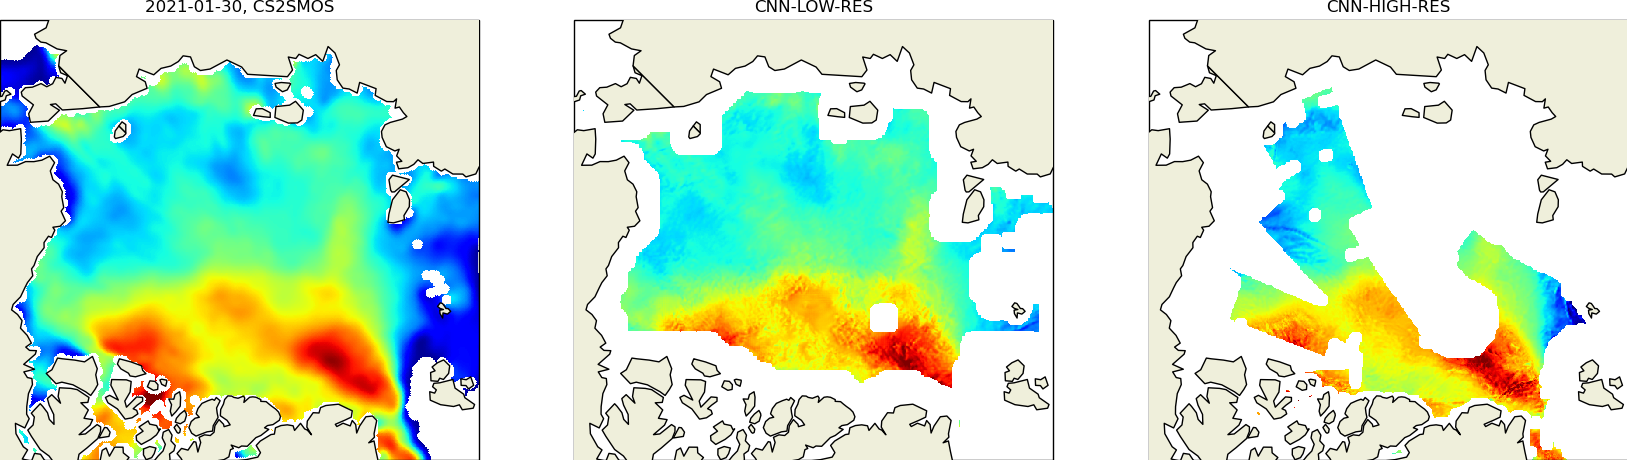

In [53]:
Image('out_029.png')

In [60]:
!ffmpeg -stream_loop 3 -y -r 10 -f image2 -i out_%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" out.mp4

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/data1/antonk/miniconda/envs/ice --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1556785800657/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 22.100 / 56. 22.100
  libavcodec     58. 35.100 / 58. 35.100
  libavformat    58. 20.100 / 58. 20.100
  libavdevice    58.  5.100 / 58.  5.100
  libavfilter     7. 40.101 /  7. 40.101
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  3.100 /  5.  3.100
  libswresample   3.  3.100 /  3.  3.100
  libpostproc    55.  3.100 / 55.  3.100
Input #0, image2, from 'out_%03d.png':
  Duration: 00:

In [66]:
!convert +map -delay 10  -loop 0 out*png out.gif